In [3]:
using Distributions
using Random
using scBayesDeconv
using Plots

# Distribution 1

In [2]:
ndist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([10],ones(1,1)),
        MultivariateNormal([100],ones(1,1))
    ],
    [.5,.5]
    )

tdist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1))
    ],
    [1.]
    )

N = 1000

t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N)))+Matrix(transpose(rand(tdist,N)));
c = sort(c,dims=1);

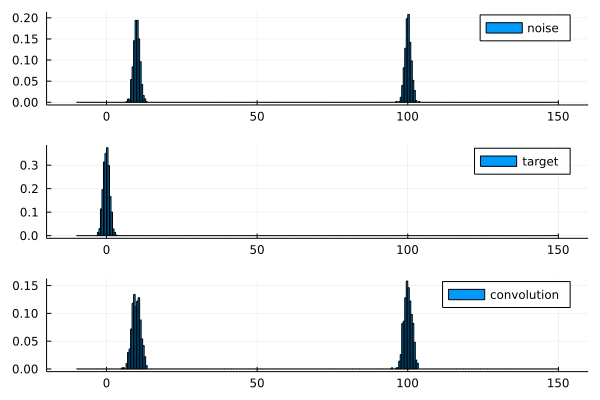

In [3]:
bins = range(-10,150,step=.5)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-10,150,step=.5)
l2 = histogram(vec(t),normalize=true,bins=bins,label="target")

bins = range(-10,150,step=.5)
l3 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

plot(l1,l2,l3,layout=(3,1))

In [4]:
dn = infiniteGaussianMixture(n,k=2,Σ0 = ones(1,1),κ0=0.01);

In [5]:
dt = infiniteGaussianMixtureDeconvolution(c,dn,k=1,Σ0=ones(1,1),κ0=0.01,ν0=0.01,α=1);

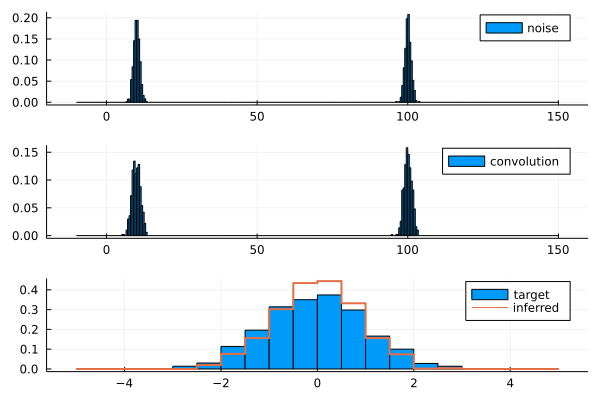

In [6]:
bins = range(-10,150,step=.5)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-10,150,step=.5)
l2 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

bins = range(-5,5,step=.5)
l3 = histogram(vec(t),normalize=true,bins=bins,label="target")
tt = rand(dt.samples[10],1000)
stephist!(l3,vec(tt),normalize=true,bins=bins,label="inferred",linewidth=2)

plot(l1,l2,l3,layout=(3,1))

# Distribution 2

In [7]:
tdist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1)),
        MultivariateNormal([3],ones(1,1))
    ],
    [.5,.5]
    )

ndist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1))
    ],
    [1.]
    )

N = 10000

t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N)))+Matrix(transpose(rand(tdist,N)));
c = sort(c,dims=1);

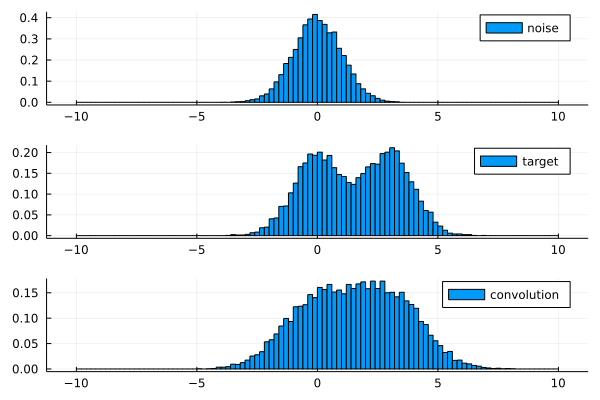

In [8]:
bins = range(-10,10,step=.2)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-10,10,step=.2)
l2 = histogram(vec(t),normalize=true,bins=bins,label="target")

bins = range(-10,10,step=.2)
l3 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

plot(l1,l2,l3,layout=(3,1))

In [9]:
dn = infiniteGaussianMixture(n,k=2,Σ0 = ones(1,1),κ0=0.01);

In [10]:
dt = infiniteGaussianMixtureDeconvolution(c,dn,k=1,Σ0=ones(1,1),κ0=0.01,ν0=0.01,α=1);

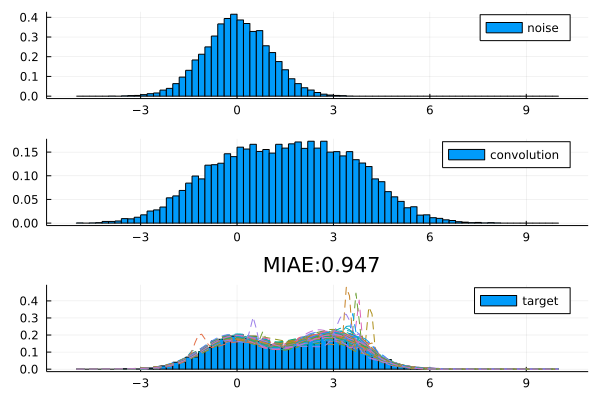

In [11]:
x = -5:.1:10

bins = range(-5,10,step=.2)
l1 = histogram(vec(n),normalize=true,bins=bins,label="noise")

bins = range(-5,10,step=.2)
l2 = histogram(vec(c),normalize=true,bins=bins,label="convolution")

f1(x) = pdf(tdist,x)
miae = []
for k in 2:10:100
    f2(x) = pdf(dt.samples[k],x)
    push!(miae, scBayesDeconv.metrics.MIAE(f1,f2,[-10. 10.],.5))
end

bins = range(-5,10,step=.2)
l3 = histogram(vec(t),normalize=true,bins=bins,label="target")

for k in 2:1:100
    y = ([pdf(dt.samples[k],[j]) for j in x])
    plot!(l3,x,y,style=:dash,label=nothing,title=string(" MIAE:",round(mean(miae),digits=3)))
end

plot(l1,l2,l3,layout=(3,1))

# Distribution 3

In [14]:
tdist = MixtureModel([
    product_distribution([Gamma(3,2),Gamma(2,3)]),
    product_distribution([Gamma(5,1),Gamma(7,7)]),
    product_distribution([Gamma(10,1.5),Gamma(10,7)]),
]
)

ndist = MixtureModel(
    [
        product_distribution([Gamma(3,2),Gamma(2,3)])
    ],
    [1.]
    )

N = 1000
t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N))).+Matrix(transpose(rand(tdist,N)));

N = 10000
theat = Matrix(transpose(rand(tdist,N)));
nheat = Matrix(transpose(rand(ndist,N)));
cheat = Matrix(transpose(rand(ndist,N))).+Matrix(transpose(rand(tdist,N)));

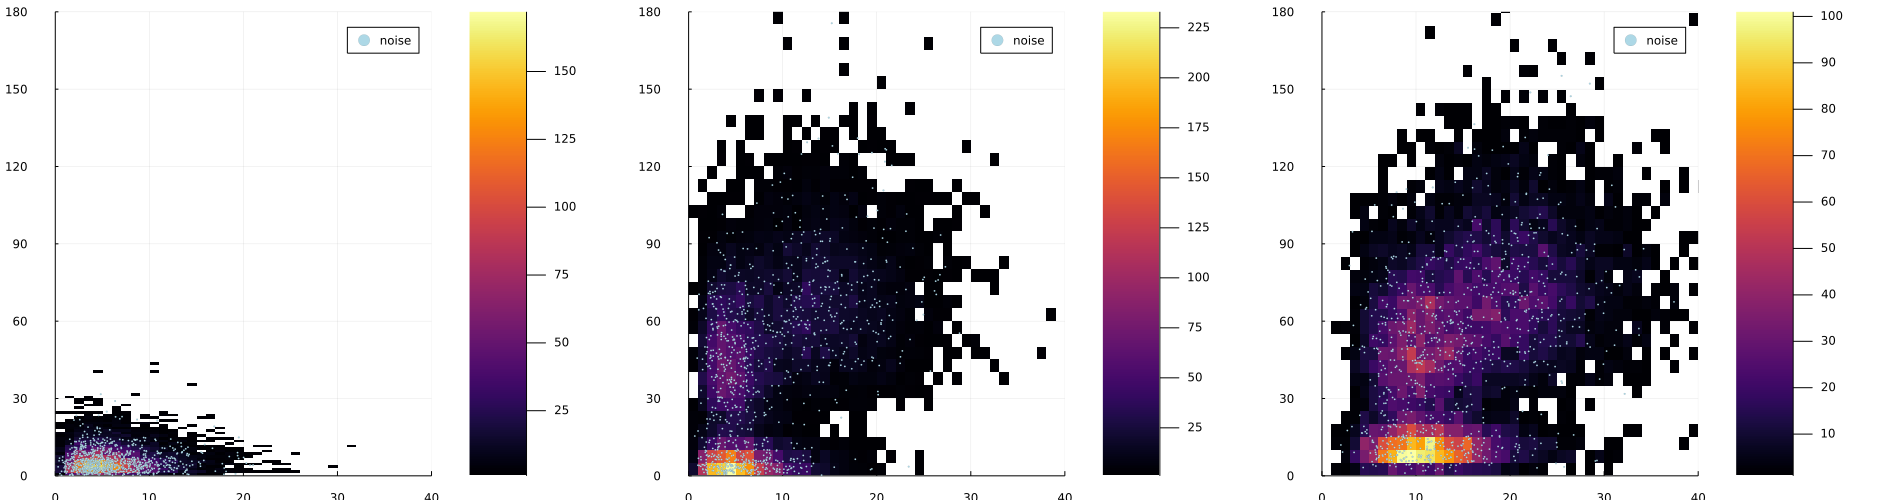

In [29]:
l1 = histogram2d(nheat[:,1],nheat[:,2],bins=50,markersize=2,label="noise")
scatter!(l1,n[:,1],n[:,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue")
xlims!(0,40)
ylims!(0,180)

l2 = histogram2d(theat[:,1],theat[:,2],bins=50,markersize=2,label="target")
scatter!(l2,t[:,1],t[:,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue")
xlims!(0,40)
ylims!(0,180)

l3 = histogram2d(cheat[:,1],cheat[:,2],bins=50,markersize=2,label="convolution")
scatter!(l3,c[:,1],c[:,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue")
xlims!(0,40)
ylims!(0,180)

plot(l1,l2,l3,layout=(1,3),size=[1900,500])

In [30]:
dn = infiniteGaussianMixture(n,k=2,κ0=0.01);

In [31]:
dt = infiniteGaussianMixtureDeconvolution(c,dn,κ0=0.001,k=1,α=1);

In [ ]:
function sample(d;distribution=:Target)

    if distribution == :Target

        N = length(d.samples)

        return d.samples[rand(1:N)]

    elseif distribution == :Noise
    
        N = length(d.noiseModel.samples)

        return d.noiseModel.samples[rand(1:N)]
    
    elseif distribution == :Convolution

        N = length(d.samples)
        component = rand(1:N)

        comp = MultivariateNormal[]
        

    else

        error("distribution can only be :Target, :Noise or :Convolution")

    end

end

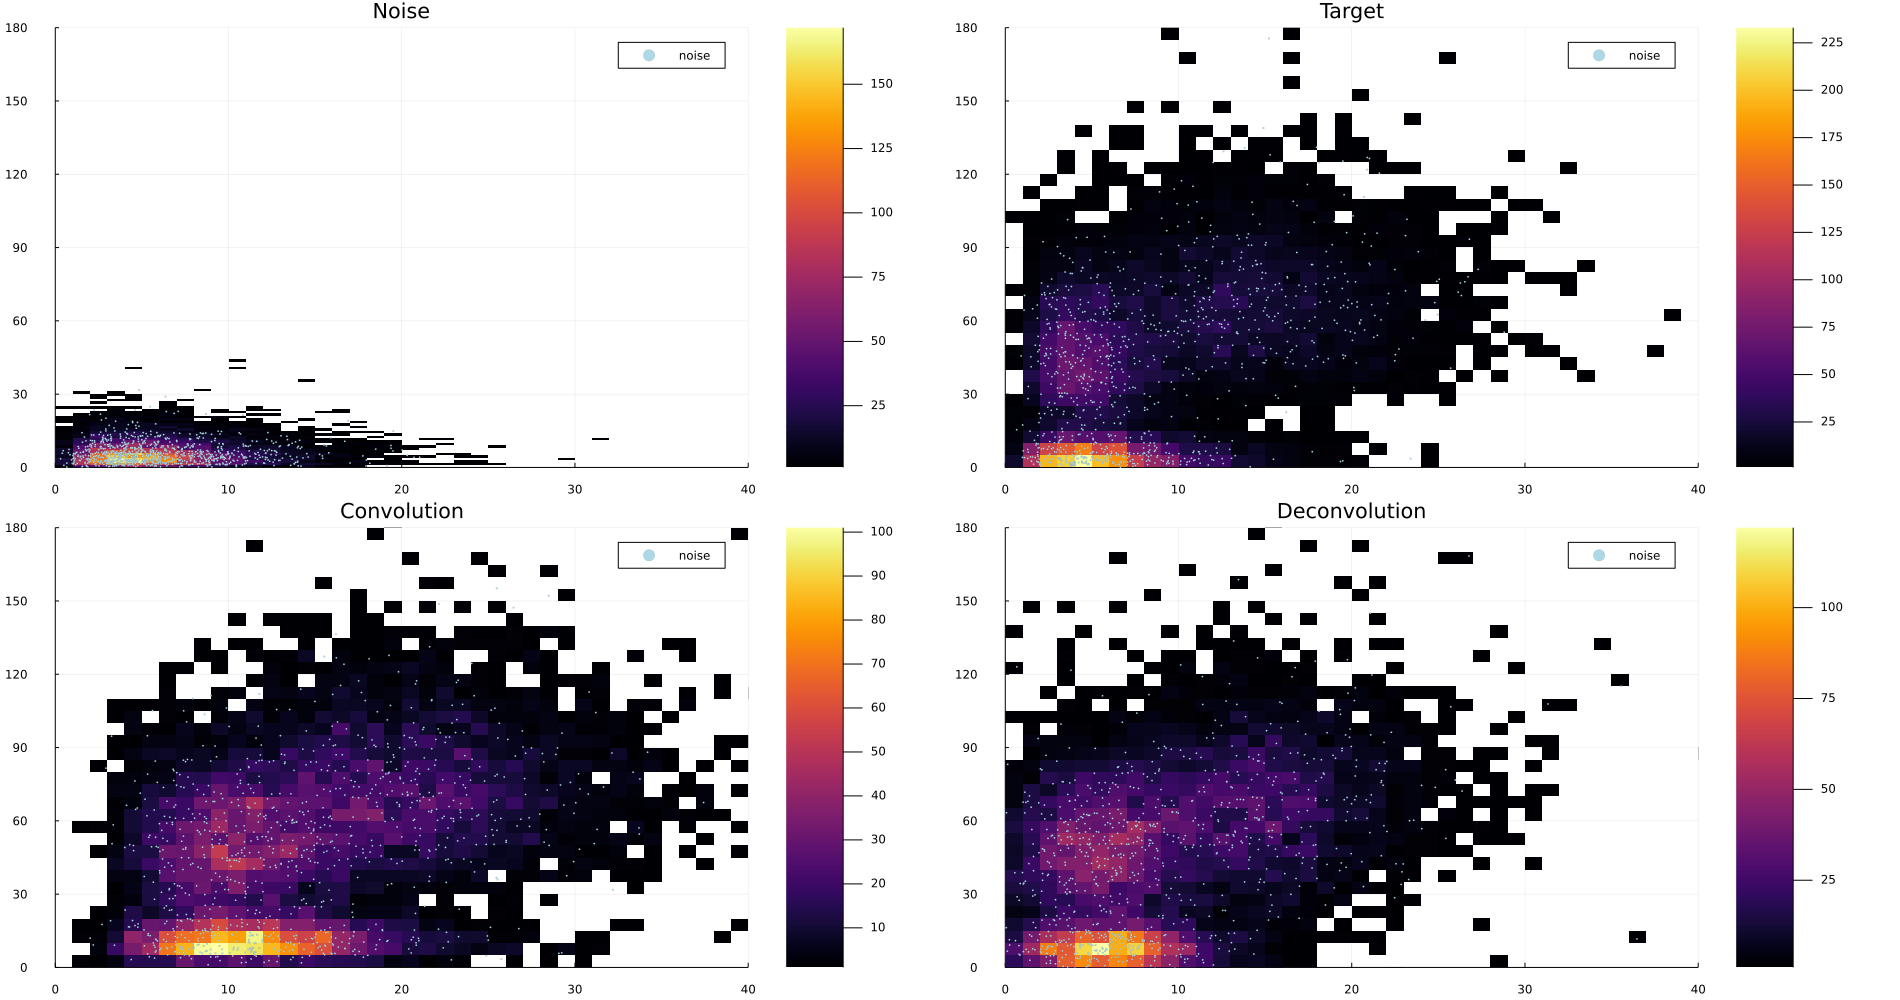

In [49]:
l1 = histogram2d(nheat[:,1],nheat[:,2],bins=50,markersize=2,label="noise")
scatter!(l1,n[:,1],n[:,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue",title="Noise")
xlims!(0,40)
ylims!(0,180)

l2 = histogram2d(theat[:,1],theat[:,2],bins=50,markersize=2,label="target")
scatter!(l2,t[:,1],t[:,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue",title="Target")
xlims!(0,40)
ylims!(0,180)

l3 = histogram2d(cheat[:,1],cheat[:,2],bins=50,markersize=2,label="convolution")
scatter!(l3,c[:,1],c[:,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue",title="Convolution")
xlims!(0,40)
ylims!(0,180)

dheat = zeros(10000,2)
for i in 1:100
    aux = rand(dt.samples[i],100)
    dheat[(i-1)*100+1:i*100, 1] .= aux[1,:]
    dheat[(i-1)*100+1:i*100, 2] .= aux[2,:]
end
l4 = histogram2d(dheat[:,1],dheat[:,2],bins=100,markersize=2,label="convolution")
scatter!(l4,dheat[1:10:10000,1],dheat[1:10:10000,2],markersize=1,markerstrokewidth=0,label="noise",color="lightblue",title="Deconvolution")
xlims!(0,40)
ylims!(0,180)

plot(l1,l2,l3,l4,layout=(2,2),size=[1900,1000])